In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import copy
import numpy as np
import math
import numpy.linalg as npla
import scipy.linalg as spla
import pickle
import pandas as pd
import plotnine as gg
import warnings
warnings.filterwarnings('ignore')

In [2]:

def round_down(val, amt):
    return amt*math.floor(val/amt)

def round_up(val, amt):
    return amt*math.ceil(val/amt)

def intervals(xmin,xmax,spacing):
    return [xmin + spacing*i for i in range(int((xmax-xmin)/spacing)+1)]

def make_hist(a, bin_length):
    a_min = np.min(a)
    a_max = np.max(a)
    # round down bin length
    hist, edges = np.histogram(a, intervals(round_down(a_min, bin_length),
                                round_up(a_max, bin_length),
                                bin_length))
    return hist, edges

def make_hist_from_std_dev(a,factor):
    s = np.std(a)
    bin_length = factor*s
    return make_hist(a, bin_length)

def make_hists(arrs, bin_length):
    a_min = np.min(arrs)
    a_max = np.max(arrs)
    # round down bin length
    li = [np.histogram(a, intervals(round_down(a_min, bin_length),
                                round_up(a_max, bin_length),
                                bin_length)) for a in arrs]
    edges = li[0][1]
    hists = [t[0] for t in li] 
    return hists, edges

def make_hists_from_std_dev(arrs, factor):
    s = np.std(arrs[0])
    bin_length = factor*s
    return make_hists(arrs, bin_length)

def tv(a1,a2):
    return np.sum(np.abs((a1-a2).astype(float)))/(2*np.sum(a1))

#first array is ground truth
def merr(arrs, factor,verbosity=1):
    (num_arrs, sample_size, d) = arrs.shape
    tvs = np.zeros((num_arrs-1, d))
    hists_list = []
    for i in range(d):
        arr_i = arrs[:,:,i]
        hists, edges = make_hists_from_std_dev(arr_i, factor)
        printv(hists, verbosity,1)
        hists_list += [hists]
        for j in range(num_arrs-1):
            tvs[j,i] = tv(hists[0], hists[j+1])
    merrs = np.sum(tvs, axis=1)/d
    return tvs, merrs, hists
#def ma(true_samples, samples, side_length):

def simple_compare(agents, num_articles, dim, var, n_steps, seed=0, verbosity=0):
    print('SEED: %d' % seed)
    env = LogisticBandit(num_articles, dim, NormalDist(0,1,dim=dim), (NormalDist(0,var,dim=dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    df = pd.DataFrame(results[0])
    cum_regrets = experiment.cum_regret
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    return results, df, cum_regrets

def redraw_samples(agent, num, verbosity=1):
    samples = []
    #theta = agent.theta
    agent_copy = copy.deepcopy(agent)
    for i in range(num):
        printv("Drawing sample %d" % (i+1), verbosity, 1)
        #agent_copy.theta= theta
        s = agent_copy.get_sample()
        samples += [s]
        printv(" "+repr(s), verbosity, 2)
    return np.asarray(samples)
#def redraw_samples_sagald(agent, num, verbosity=1):

def redraw_samples_for_agents(agents, num, verbosity=1):
    samples_list = []

    for agent in agents:
        samples = redraw_samples(agent, num, verbosity)
        samples_list += [samples]
    samples_list = np.asarray(samples_list)
    return samples_list

In [3]:
num_articles = 1
dim = 20
var = 1.0/9
theta_mean = 0
theta_std = 1

time_limit= 0.1
T=1000

verbosity=0

In [4]:
# We will tune the Langevin, SGLD, and SAGA-LD agents.

make_langevin_agent = lambda: BasicLangevinTS(num_articles, dim, [0]*(dim), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)
make_mala_agent = lambda: MalaTS(num_articles, dim, [0]*(dim), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)
make_sgld_agent = lambda: SGLDTS(num_articles, dim, [0]*(dim), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = 32,
                                        time=time_limit,
                                        n_steps=99999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda: SAGATS(num_articles, dim, [0]*(dim), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=99999,
                                          init_pt=None, verbosity=verbosity)

# Untimed MALA agent is used as baseline.

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim, [0]*dim, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.
theta_mean = 0
theta_std = 1
epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=False, context_has_constant=False, 
                                      n_steps=99999, time = time_limit, verbosity=verbosity)

# Experiments

* Try running for 10,000 trials.

In [5]:
num_articles = 1
dim = 20
var = 1.0/9
theta_mean = 0
theta_std = 1

time_limit= 0.01
T=10000

verbosity=0

# We will tune the Langevin, SGLD, and SAGA-LD agents.
make_mala_agent = lambda: MalaTS(num_articles, dim, [0]*(dim), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)
make_sgld_agent = lambda: SGLDTS(num_articles, dim, [0]*(dim), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(dim*var)/dim),
                                        batch_size = 32,
                                        time=time_limit,
                                        n_steps=99999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda: SAGATS(num_articles, dim, [0]*(dim), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(dim*var)/dim),
                                          batch_size = 32,
                                          time=time_limit,
                                          n_steps=99999,
                                          init_pt=None, verbosity=verbosity)

# Untimed MALA agent is used as baseline.

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim, [0]*dim, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(dim*var)/dim), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.
theta_mean = 0
theta_std = 1
epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=False, context_has_constant=False, 
                                      n_steps=99999, time = time_limit, verbosity=verbosity)

SEED: 11
theta [ 1.74945474 -0.286073   -0.48456513 -2.65331856 -0.00828463 -0.31963136
 -0.53662936  0.31540267  0.42105072 -1.06560298 -0.88623967 -0.47573349
  0.68968231  0.56119218 -1.30554851 -1.11947526  0.73683739  1.57463407
 -0.03107509 -0.68344663]
Experiment: Step 0
Experiment: Step 1
Experiment: Step 2
Experiment: Step 3
Experiment: Step 4
Experiment: Step 5
Experiment: Step 6
Experiment: Step 7
Experiment: Step 8
Experiment: Step 9
Experiment: Step 10
Experiment: Step 11
Experiment: Step 12
Experiment: Step 13
Experiment: Step 14
Experiment: Step 15
Experiment: Step 16
Experiment: Step 17
Experiment: Step 18
Experiment: Step 19
Experiment: Step 20
Experiment: Step 21
Experiment: Step 22
Experiment: Step 23
Experiment: Step 24
Experiment: Step 25
Experiment: Step 26
Experiment: Step 27
Experiment: Step 28
Experiment: Step 29
Experiment: Step 30
Experiment: Step 31
Experiment: Step 32
Experiment: Step 33
Experiment: Step 34
Experiment: Step 35
Experiment: Step 36
Experiment

Experiment: Step 387
Experiment: Step 388
Experiment: Step 389
Experiment: Step 390
Experiment: Step 391
Experiment: Step 392
Experiment: Step 393
Experiment: Step 394
Experiment: Step 395
Experiment: Step 396
Experiment: Step 397
Experiment: Step 398
Experiment: Step 399
Experiment: Step 400
Experiment: Step 401
Experiment: Step 402
Experiment: Step 403
Experiment: Step 404
Experiment: Step 405
Experiment: Step 406
Experiment: Step 407
Experiment: Step 408
Experiment: Step 409
Experiment: Step 410
Experiment: Step 411
Experiment: Step 412
Experiment: Step 413
Experiment: Step 414
Experiment: Step 415
Experiment: Step 416
Experiment: Step 417
Experiment: Step 418
Experiment: Step 419
Experiment: Step 420
Experiment: Step 421
Experiment: Step 422
Experiment: Step 423
Experiment: Step 424
Experiment: Step 425
Experiment: Step 426
Experiment: Step 427
Experiment: Step 428
Experiment: Step 429
Experiment: Step 430
Experiment: Step 431
Experiment: Step 432
Experiment: Step 433
Experiment: S

Experiment: Step 778
Experiment: Step 779
Experiment: Step 780
Experiment: Step 781
Experiment: Step 782
Experiment: Step 783
Experiment: Step 784
Experiment: Step 785
Experiment: Step 786
Experiment: Step 787
Experiment: Step 788
Experiment: Step 789
Experiment: Step 790
Experiment: Step 791
Experiment: Step 792
Experiment: Step 793
Experiment: Step 794
Experiment: Step 795
Experiment: Step 796
Experiment: Step 797
Experiment: Step 798
Experiment: Step 799
Experiment: Step 800
Experiment: Step 801
Experiment: Step 802
Experiment: Step 803
Experiment: Step 804
Experiment: Step 805
Experiment: Step 806
Experiment: Step 807
Experiment: Step 808
Experiment: Step 809
Experiment: Step 810
Experiment: Step 811
Experiment: Step 812
Experiment: Step 813
Experiment: Step 814
Experiment: Step 815
Experiment: Step 816
Experiment: Step 817
Experiment: Step 818
Experiment: Step 819
Experiment: Step 820
Experiment: Step 821
Experiment: Step 822
Experiment: Step 823
Experiment: Step 824
Experiment: S

Experiment: Step 1162
Experiment: Step 1163
Experiment: Step 1164
Experiment: Step 1165
Experiment: Step 1166
Experiment: Step 1167
Experiment: Step 1168
Experiment: Step 1169
Experiment: Step 1170
Experiment: Step 1171
Experiment: Step 1172
Experiment: Step 1173
Experiment: Step 1174
Experiment: Step 1175
Experiment: Step 1176
Experiment: Step 1177
Experiment: Step 1178
Experiment: Step 1179
Experiment: Step 1180
Experiment: Step 1181
Experiment: Step 1182
Experiment: Step 1183
Experiment: Step 1184
Experiment: Step 1185
Experiment: Step 1186
Experiment: Step 1187
Experiment: Step 1188
Experiment: Step 1189
Experiment: Step 1190
Experiment: Step 1191
Experiment: Step 1192
Experiment: Step 1193
Experiment: Step 1194
Experiment: Step 1195
Experiment: Step 1196
Experiment: Step 1197
Experiment: Step 1198
Experiment: Step 1199
Experiment: Step 1200
Experiment: Step 1201
Experiment: Step 1202
Experiment: Step 1203
Experiment: Step 1204
Experiment: Step 1205
Experiment: Step 1206
Experiment

Experiment: Step 1536
Experiment: Step 1537
Experiment: Step 1538
Experiment: Step 1539
Experiment: Step 1540
Experiment: Step 1541
Experiment: Step 1542
Experiment: Step 1543
Experiment: Step 1544
Experiment: Step 1545
Experiment: Step 1546
Experiment: Step 1547
Experiment: Step 1548
Experiment: Step 1549
Experiment: Step 1550
Experiment: Step 1551
Experiment: Step 1552
Experiment: Step 1553
Experiment: Step 1554
Experiment: Step 1555
Experiment: Step 1556
Experiment: Step 1557
Experiment: Step 1558
Experiment: Step 1559
Experiment: Step 1560
Experiment: Step 1561
Experiment: Step 1562
Experiment: Step 1563
Experiment: Step 1564
Experiment: Step 1565
Experiment: Step 1566
Experiment: Step 1567
Experiment: Step 1568
Experiment: Step 1569
Experiment: Step 1570
Experiment: Step 1571
Experiment: Step 1572
Experiment: Step 1573
Experiment: Step 1574
Experiment: Step 1575
Experiment: Step 1576
Experiment: Step 1577
Experiment: Step 1578
Experiment: Step 1579
Experiment: Step 1580
Experiment

Experiment: Step 1910
Experiment: Step 1911
Experiment: Step 1912
Experiment: Step 1913
Experiment: Step 1914
Experiment: Step 1915
Experiment: Step 1916
Experiment: Step 1917
Experiment: Step 1918
Experiment: Step 1919
Experiment: Step 1920
Experiment: Step 1921
Experiment: Step 1922
Experiment: Step 1923
Experiment: Step 1924
Experiment: Step 1925
Experiment: Step 1926
Experiment: Step 1927
Experiment: Step 1928
Experiment: Step 1929
Experiment: Step 1930
Experiment: Step 1931
Experiment: Step 1932
Experiment: Step 1933
Experiment: Step 1934
Experiment: Step 1935
Experiment: Step 1936
Experiment: Step 1937
Experiment: Step 1938
Experiment: Step 1939
Experiment: Step 1940
Experiment: Step 1941
Experiment: Step 1942
Experiment: Step 1943
Experiment: Step 1944
Experiment: Step 1945
Experiment: Step 1946
Experiment: Step 1947
Experiment: Step 1948
Experiment: Step 1949
Experiment: Step 1950
Experiment: Step 1951
Experiment: Step 1952
Experiment: Step 1953
Experiment: Step 1954
Experiment

Experiment: Step 2283
Experiment: Step 2284
Experiment: Step 2285
Experiment: Step 2286
Experiment: Step 2287
Experiment: Step 2288
Experiment: Step 2289
Experiment: Step 2290
Experiment: Step 2291
Experiment: Step 2292
Experiment: Step 2293
Experiment: Step 2294
Experiment: Step 2295
Experiment: Step 2296
Experiment: Step 2297
Experiment: Step 2298
Experiment: Step 2299
Experiment: Step 2300
Experiment: Step 2301
Experiment: Step 2302
Experiment: Step 2303
Experiment: Step 2304
Experiment: Step 2305
Experiment: Step 2306
Experiment: Step 2307
Experiment: Step 2308
Experiment: Step 2309
Experiment: Step 2310
Experiment: Step 2311
Experiment: Step 2312
Experiment: Step 2313
Experiment: Step 2314
Experiment: Step 2315
Experiment: Step 2316
Experiment: Step 2317
Experiment: Step 2318
Experiment: Step 2319
Experiment: Step 2320
Experiment: Step 2321
Experiment: Step 2322
Experiment: Step 2323
Experiment: Step 2324
Experiment: Step 2325
Experiment: Step 2326
Experiment: Step 2327
Experiment

Experiment: Step 2656
Experiment: Step 2657
Experiment: Step 2658
Experiment: Step 2659
Experiment: Step 2660
Experiment: Step 2661
Experiment: Step 2662
Experiment: Step 2663
Experiment: Step 2664
Experiment: Step 2665
Experiment: Step 2666
Experiment: Step 2667
Experiment: Step 2668
Experiment: Step 2669
Experiment: Step 2670
Experiment: Step 2671
Experiment: Step 2672
Experiment: Step 2673
Experiment: Step 2674
Experiment: Step 2675
Experiment: Step 2676
Experiment: Step 2677
Experiment: Step 2678
Experiment: Step 2679
Experiment: Step 2680
Experiment: Step 2681
Experiment: Step 2682
Experiment: Step 2683
Experiment: Step 2684
Experiment: Step 2685
Experiment: Step 2686
Experiment: Step 2687
Experiment: Step 2688
Experiment: Step 2689
Experiment: Step 2690
Experiment: Step 2691
Experiment: Step 2692
Experiment: Step 2693
Experiment: Step 2694
Experiment: Step 2695
Experiment: Step 2696
Experiment: Step 2697
Experiment: Step 2698
Experiment: Step 2699
Experiment: Step 2700
Experiment

Experiment: Step 3029
Experiment: Step 3030
Experiment: Step 3031
Experiment: Step 3032
Experiment: Step 3033
Experiment: Step 3034
Experiment: Step 3035
Experiment: Step 3036
Experiment: Step 3037
Experiment: Step 3038
Experiment: Step 3039
Experiment: Step 3040
Experiment: Step 3041
Experiment: Step 3042
Experiment: Step 3043
Experiment: Step 3044
Experiment: Step 3045
Experiment: Step 3046
Experiment: Step 3047
Experiment: Step 3048
Experiment: Step 3049
Experiment: Step 3050
Experiment: Step 3051
Experiment: Step 3052
Experiment: Step 3053
Experiment: Step 3054
Experiment: Step 3055
Experiment: Step 3056
Experiment: Step 3057
Experiment: Step 3058
Experiment: Step 3059
Experiment: Step 3060
Experiment: Step 3061
Experiment: Step 3062
Experiment: Step 3063
Experiment: Step 3064
Experiment: Step 3065
Experiment: Step 3066
Experiment: Step 3067
Experiment: Step 3068
Experiment: Step 3069
Experiment: Step 3070
Experiment: Step 3071
Experiment: Step 3072
Experiment: Step 3073
Experiment

Experiment: Step 3402
Experiment: Step 3403
Experiment: Step 3404
Experiment: Step 3405
Experiment: Step 3406
Experiment: Step 3407
Experiment: Step 3408
Experiment: Step 3409
Experiment: Step 3410
Experiment: Step 3411
Experiment: Step 3412
Experiment: Step 3413
Experiment: Step 3414
Experiment: Step 3415
Experiment: Step 3416
Experiment: Step 3417
Experiment: Step 3418
Experiment: Step 3419
Experiment: Step 3420
Experiment: Step 3421
Experiment: Step 3422
Experiment: Step 3423
Experiment: Step 3424
Experiment: Step 3425
Experiment: Step 3426
Experiment: Step 3427
Experiment: Step 3428
Experiment: Step 3429
Experiment: Step 3430
Experiment: Step 3431
Experiment: Step 3432
Experiment: Step 3433
Experiment: Step 3434
Experiment: Step 3435
Experiment: Step 3436
Experiment: Step 3437
Experiment: Step 3438
Experiment: Step 3439
Experiment: Step 3440
Experiment: Step 3441
Experiment: Step 3442
Experiment: Step 3443
Experiment: Step 3444
Experiment: Step 3445
Experiment: Step 3446
Experiment

Experiment: Step 3775
Experiment: Step 3776
Experiment: Step 3777
Experiment: Step 3778
Experiment: Step 3779
Experiment: Step 3780
Experiment: Step 3781
Experiment: Step 3782
Experiment: Step 3783
Experiment: Step 3784
Experiment: Step 3785
Experiment: Step 3786
Experiment: Step 3787
Experiment: Step 3788
Experiment: Step 3789
Experiment: Step 3790
Experiment: Step 3791
Experiment: Step 3792
Experiment: Step 3793
Experiment: Step 3794
Experiment: Step 3795
Experiment: Step 3796
Experiment: Step 3797
Experiment: Step 3798
Experiment: Step 3799
Experiment: Step 3800
Experiment: Step 3801
Experiment: Step 3802
Experiment: Step 3803
Experiment: Step 3804
Experiment: Step 3805
Experiment: Step 3806
Experiment: Step 3807
Experiment: Step 3808
Experiment: Step 3809
Experiment: Step 3810
Experiment: Step 3811
Experiment: Step 3812
Experiment: Step 3813
Experiment: Step 3814
Experiment: Step 3815
Experiment: Step 3816
Experiment: Step 3817
Experiment: Step 3818
Experiment: Step 3819
Experiment

Experiment: Step 4148
Experiment: Step 4149
Experiment: Step 4150
Experiment: Step 4151
Experiment: Step 4152
Experiment: Step 4153
Experiment: Step 4154
Experiment: Step 4155
Experiment: Step 4156
Experiment: Step 4157
Experiment: Step 4158
Experiment: Step 4159
Experiment: Step 4160
Experiment: Step 4161
Experiment: Step 4162
Experiment: Step 4163
Experiment: Step 4164
Experiment: Step 4165
Experiment: Step 4166
Experiment: Step 4167
Experiment: Step 4168
Experiment: Step 4169
Experiment: Step 4170
Experiment: Step 4171
Experiment: Step 4172
Experiment: Step 4173
Experiment: Step 4174
Experiment: Step 4175
Experiment: Step 4176
Experiment: Step 4177
Experiment: Step 4178
Experiment: Step 4179
Experiment: Step 4180
Experiment: Step 4181
Experiment: Step 4182
Experiment: Step 4183
Experiment: Step 4184
Experiment: Step 4185
Experiment: Step 4186
Experiment: Step 4187
Experiment: Step 4188
Experiment: Step 4189
Experiment: Step 4190
Experiment: Step 4191
Experiment: Step 4192
Experiment

Experiment: Step 4521
Experiment: Step 4522
Experiment: Step 4523
Experiment: Step 4524
Experiment: Step 4525
Experiment: Step 4526
Experiment: Step 4527
Experiment: Step 4528
Experiment: Step 4529
Experiment: Step 4530
Experiment: Step 4531
Experiment: Step 4532
Experiment: Step 4533
Experiment: Step 4534
Experiment: Step 4535
Experiment: Step 4536
Experiment: Step 4537
Experiment: Step 4538
Experiment: Step 4539
Experiment: Step 4540
Experiment: Step 4541
Experiment: Step 4542
Experiment: Step 4543
Experiment: Step 4544
Experiment: Step 4545
Experiment: Step 4546
Experiment: Step 4547
Experiment: Step 4548
Experiment: Step 4549
Experiment: Step 4550
Experiment: Step 4551
Experiment: Step 4552
Experiment: Step 4553
Experiment: Step 4554
Experiment: Step 4555
Experiment: Step 4556
Experiment: Step 4557
Experiment: Step 4558
Experiment: Step 4559
Experiment: Step 4560
Experiment: Step 4561
Experiment: Step 4562
Experiment: Step 4563
Experiment: Step 4564
Experiment: Step 4565
Experiment

Experiment: Step 4894
Experiment: Step 4895
Experiment: Step 4896
Experiment: Step 4897
Experiment: Step 4898
Experiment: Step 4899
Experiment: Step 4900
Experiment: Step 4901
Experiment: Step 4902
Experiment: Step 4903
Experiment: Step 4904
Experiment: Step 4905
Experiment: Step 4906
Experiment: Step 4907
Experiment: Step 4908
Experiment: Step 4909
Experiment: Step 4910
Experiment: Step 4911
Experiment: Step 4912
Experiment: Step 4913
Experiment: Step 4914
Experiment: Step 4915
Experiment: Step 4916
Experiment: Step 4917
Experiment: Step 4918
Experiment: Step 4919
Experiment: Step 4920
Experiment: Step 4921
Experiment: Step 4922
Experiment: Step 4923
Experiment: Step 4924
Experiment: Step 4925
Experiment: Step 4926
Experiment: Step 4927
Experiment: Step 4928
Experiment: Step 4929
Experiment: Step 4930
Experiment: Step 4931
Experiment: Step 4932
Experiment: Step 4933
Experiment: Step 4934
Experiment: Step 4935
Experiment: Step 4936
Experiment: Step 4937
Experiment: Step 4938
Experiment

Experiment: Step 5267
Experiment: Step 5268
Experiment: Step 5269
Experiment: Step 5270
Experiment: Step 5271
Experiment: Step 5272
Experiment: Step 5273
Experiment: Step 5274
Experiment: Step 5275
Experiment: Step 5276
Experiment: Step 5277
Experiment: Step 5278
Experiment: Step 5279
Experiment: Step 5280
Experiment: Step 5281
Experiment: Step 5282
Experiment: Step 5283
Experiment: Step 5284
Experiment: Step 5285
Experiment: Step 5286
Experiment: Step 5287
Experiment: Step 5288
Experiment: Step 5289
Experiment: Step 5290
Experiment: Step 5291
Experiment: Step 5292
Experiment: Step 5293
Experiment: Step 5294
Experiment: Step 5295
Experiment: Step 5296
Experiment: Step 5297
Experiment: Step 5298
Experiment: Step 5299
Experiment: Step 5300
Experiment: Step 5301
Experiment: Step 5302
Experiment: Step 5303
Experiment: Step 5304
Experiment: Step 5305
Experiment: Step 5306
Experiment: Step 5307
Experiment: Step 5308
Experiment: Step 5309
Experiment: Step 5310
Experiment: Step 5311
Experiment

Experiment: Step 5640
Experiment: Step 5641
Experiment: Step 5642
Experiment: Step 5643
Experiment: Step 5644
Experiment: Step 5645
Experiment: Step 5646
Experiment: Step 5647
Experiment: Step 5648
Experiment: Step 5649
Experiment: Step 5650
Experiment: Step 5651
Experiment: Step 5652
Experiment: Step 5653
Experiment: Step 5654
Experiment: Step 5655
Experiment: Step 5656
Experiment: Step 5657
Experiment: Step 5658
Experiment: Step 5659
Experiment: Step 5660
Experiment: Step 5661
Experiment: Step 5662
Experiment: Step 5663
Experiment: Step 5664
Experiment: Step 5665
Experiment: Step 5666
Experiment: Step 5667
Experiment: Step 5668
Experiment: Step 5669
Experiment: Step 5670
Experiment: Step 5671
Experiment: Step 5672
Experiment: Step 5673
Experiment: Step 5674
Experiment: Step 5675
Experiment: Step 5676
Experiment: Step 5677
Experiment: Step 5678
Experiment: Step 5679
Experiment: Step 5680
Experiment: Step 5681
Experiment: Step 5682
Experiment: Step 5683
Experiment: Step 5684
Experiment

Experiment: Step 6013
Experiment: Step 6014
Experiment: Step 6015
Experiment: Step 6016
Experiment: Step 6017
Experiment: Step 6018
Experiment: Step 6019
Experiment: Step 6020
Experiment: Step 6021
Experiment: Step 6022
Experiment: Step 6023
Experiment: Step 6024
Experiment: Step 6025
Experiment: Step 6026
Experiment: Step 6027
Experiment: Step 6028
Experiment: Step 6029
Experiment: Step 6030
Experiment: Step 6031
Experiment: Step 6032
Experiment: Step 6033
Experiment: Step 6034
Experiment: Step 6035
Experiment: Step 6036
Experiment: Step 6037
Experiment: Step 6038
Experiment: Step 6039
Experiment: Step 6040
Experiment: Step 6041
Experiment: Step 6042
Experiment: Step 6043
Experiment: Step 6044
Experiment: Step 6045
Experiment: Step 6046
Experiment: Step 6047
Experiment: Step 6048
Experiment: Step 6049
Experiment: Step 6050
Experiment: Step 6051
Experiment: Step 6052
Experiment: Step 6053
Experiment: Step 6054
Experiment: Step 6055
Experiment: Step 6056
Experiment: Step 6057
Experiment

Experiment: Step 6386
Experiment: Step 6387
Experiment: Step 6388
Experiment: Step 6389
Experiment: Step 6390
Experiment: Step 6391
Experiment: Step 6392
Experiment: Step 6393
Experiment: Step 6394
Experiment: Step 6395
Experiment: Step 6396
Experiment: Step 6397
Experiment: Step 6398
Experiment: Step 6399
Experiment: Step 6400
Experiment: Step 6401
Experiment: Step 6402
Experiment: Step 6403
Experiment: Step 6404
Experiment: Step 6405
Experiment: Step 6406
Experiment: Step 6407
Experiment: Step 6408
Experiment: Step 6409
Experiment: Step 6410
Experiment: Step 6411
Experiment: Step 6412
Experiment: Step 6413
Experiment: Step 6414
Experiment: Step 6415
Experiment: Step 6416
Experiment: Step 6417
Experiment: Step 6418
Experiment: Step 6419
Experiment: Step 6420
Experiment: Step 6421
Experiment: Step 6422
Experiment: Step 6423
Experiment: Step 6424
Experiment: Step 6425
Experiment: Step 6426
Experiment: Step 6427
Experiment: Step 6428
Experiment: Step 6429
Experiment: Step 6430
Experiment

Experiment: Step 6759
Experiment: Step 6760
Experiment: Step 6761
Experiment: Step 6762
Experiment: Step 6763
Experiment: Step 6764
Experiment: Step 6765
Experiment: Step 6766
Experiment: Step 6767
Experiment: Step 6768
Experiment: Step 6769
Experiment: Step 6770
Experiment: Step 6771
Experiment: Step 6772
Experiment: Step 6773
Experiment: Step 6774
Experiment: Step 6775
Experiment: Step 6776
Experiment: Step 6777
Experiment: Step 6778
Experiment: Step 6779
Experiment: Step 6780
Experiment: Step 6781
Experiment: Step 6782
Experiment: Step 6783
Experiment: Step 6784
Experiment: Step 6785
Experiment: Step 6786
Experiment: Step 6787
Experiment: Step 6788
Experiment: Step 6789
Experiment: Step 6790
Experiment: Step 6791
Experiment: Step 6792
Experiment: Step 6793
Experiment: Step 6794
Experiment: Step 6795
Experiment: Step 6796
Experiment: Step 6797
Experiment: Step 6798
Experiment: Step 6799
Experiment: Step 6800
Experiment: Step 6801
Experiment: Step 6802
Experiment: Step 6803
Experiment

Experiment: Step 7132
Experiment: Step 7133
Experiment: Step 7134
Experiment: Step 7135
Experiment: Step 7136
Experiment: Step 7137
Experiment: Step 7138
Experiment: Step 7139
Experiment: Step 7140
Experiment: Step 7141
Experiment: Step 7142
Experiment: Step 7143
Experiment: Step 7144
Experiment: Step 7145
Experiment: Step 7146
Experiment: Step 7147
Experiment: Step 7148
Experiment: Step 7149
Experiment: Step 7150
Experiment: Step 7151
Experiment: Step 7152
Experiment: Step 7153
Experiment: Step 7154
Experiment: Step 7155
Experiment: Step 7156
Experiment: Step 7157
Experiment: Step 7158
Experiment: Step 7159
Experiment: Step 7160
Experiment: Step 7161
Experiment: Step 7162
Experiment: Step 7163
Experiment: Step 7164
Experiment: Step 7165
Experiment: Step 7166
Experiment: Step 7167
Experiment: Step 7168
Experiment: Step 7169
Experiment: Step 7170
Experiment: Step 7171
Experiment: Step 7172
Experiment: Step 7173
Experiment: Step 7174
Experiment: Step 7175
Experiment: Step 7176
Experiment

Experiment: Step 7505
Experiment: Step 7506
Experiment: Step 7507
Experiment: Step 7508
Experiment: Step 7509
Experiment: Step 7510
Experiment: Step 7511
Experiment: Step 7512
Experiment: Step 7513
Experiment: Step 7514
Experiment: Step 7515
Experiment: Step 7516
Experiment: Step 7517
Experiment: Step 7518
Experiment: Step 7519
Experiment: Step 7520
Experiment: Step 7521
Experiment: Step 7522
Experiment: Step 7523
Experiment: Step 7524
Experiment: Step 7525
Experiment: Step 7526
Experiment: Step 7527
Experiment: Step 7528
Experiment: Step 7529
Experiment: Step 7530
Experiment: Step 7531
Experiment: Step 7532
Experiment: Step 7533
Experiment: Step 7534
Experiment: Step 7535
Experiment: Step 7536
Experiment: Step 7537
Experiment: Step 7538
Experiment: Step 7539
Experiment: Step 7540
Experiment: Step 7541
Experiment: Step 7542
Experiment: Step 7543
Experiment: Step 7544
Experiment: Step 7545
Experiment: Step 7546
Experiment: Step 7547
Experiment: Step 7548
Experiment: Step 7549
Experiment

Experiment: Step 7878
Experiment: Step 7879
Experiment: Step 7880
Experiment: Step 7881
Experiment: Step 7882
Experiment: Step 7883
Experiment: Step 7884
Experiment: Step 7885
Experiment: Step 7886
Experiment: Step 7887
Experiment: Step 7888
Experiment: Step 7889
Experiment: Step 7890
Experiment: Step 7891
Experiment: Step 7892
Experiment: Step 7893
Experiment: Step 7894
Experiment: Step 7895
Experiment: Step 7896
Experiment: Step 7897
Experiment: Step 7898
Experiment: Step 7899
Experiment: Step 7900
Experiment: Step 7901
Experiment: Step 7902
Experiment: Step 7903
Experiment: Step 7904
Experiment: Step 7905
Experiment: Step 7906
Experiment: Step 7907
Experiment: Step 7908
Experiment: Step 7909
Experiment: Step 7910
Experiment: Step 7911
Experiment: Step 7912
Experiment: Step 7913
Experiment: Step 7914
Experiment: Step 7915
Experiment: Step 7916
Experiment: Step 7917
Experiment: Step 7918
Experiment: Step 7919
Experiment: Step 7920
Experiment: Step 7921
Experiment: Step 7922
Experiment

Experiment: Step 8251
Experiment: Step 8252
Experiment: Step 8253
Experiment: Step 8254
Experiment: Step 8255
Experiment: Step 8256
Experiment: Step 8257
Experiment: Step 8258
Experiment: Step 8259
Experiment: Step 8260
Experiment: Step 8261
Experiment: Step 8262
Experiment: Step 8263
Experiment: Step 8264
Experiment: Step 8265
Experiment: Step 8266
Experiment: Step 8267
Experiment: Step 8268
Experiment: Step 8269
Experiment: Step 8270
Experiment: Step 8271
Experiment: Step 8272
Experiment: Step 8273
Experiment: Step 8274
Experiment: Step 8275
Experiment: Step 8276
Experiment: Step 8277
Experiment: Step 8278
Experiment: Step 8279
Experiment: Step 8280
Experiment: Step 8281
Experiment: Step 8282
Experiment: Step 8283
Experiment: Step 8284
Experiment: Step 8285
Experiment: Step 8286
Experiment: Step 8287
Experiment: Step 8288
Experiment: Step 8289
Experiment: Step 8290
Experiment: Step 8291
Experiment: Step 8292
Experiment: Step 8293
Experiment: Step 8294
Experiment: Step 8295
Experiment

Experiment: Step 8624
Experiment: Step 8625
Experiment: Step 8626
Experiment: Step 8627
Experiment: Step 8628
Experiment: Step 8629
Experiment: Step 8630
Experiment: Step 8631
Experiment: Step 8632
Experiment: Step 8633
Experiment: Step 8634
Experiment: Step 8635
Experiment: Step 8636
Experiment: Step 8637
Experiment: Step 8638
Experiment: Step 8639
Experiment: Step 8640
Experiment: Step 8641
Experiment: Step 8642
Experiment: Step 8643
Experiment: Step 8644
Experiment: Step 8645
Experiment: Step 8646
Experiment: Step 8647
Experiment: Step 8648
Experiment: Step 8649
Experiment: Step 8650
Experiment: Step 8651
Experiment: Step 8652
Experiment: Step 8653
Experiment: Step 8654
Experiment: Step 8655
Experiment: Step 8656
Experiment: Step 8657
Experiment: Step 8658
Experiment: Step 8659
Experiment: Step 8660
Experiment: Step 8661
Experiment: Step 8662
Experiment: Step 8663
Experiment: Step 8664
Experiment: Step 8665
Experiment: Step 8666
Experiment: Step 8667
Experiment: Step 8668
Experiment

Experiment: Step 8997
Experiment: Step 8998
Experiment: Step 8999
Experiment: Step 9000
Experiment: Step 9001
Experiment: Step 9002
Experiment: Step 9003
Experiment: Step 9004
Experiment: Step 9005
Experiment: Step 9006
Experiment: Step 9007
Experiment: Step 9008
Experiment: Step 9009
Experiment: Step 9010
Experiment: Step 9011
Experiment: Step 9012
Experiment: Step 9013
Experiment: Step 9014
Experiment: Step 9015
Experiment: Step 9016
Experiment: Step 9017
Experiment: Step 9018
Experiment: Step 9019
Experiment: Step 9020
Experiment: Step 9021
Experiment: Step 9022
Experiment: Step 9023
Experiment: Step 9024
Experiment: Step 9025
Experiment: Step 9026
Experiment: Step 9027
Experiment: Step 9028
Experiment: Step 9029
Experiment: Step 9030
Experiment: Step 9031
Experiment: Step 9032
Experiment: Step 9033
Experiment: Step 9034
Experiment: Step 9035
Experiment: Step 9036
Experiment: Step 9037
Experiment: Step 9038
Experiment: Step 9039
Experiment: Step 9040
Experiment: Step 9041
Experiment

Experiment: Step 9370
Experiment: Step 9371
Experiment: Step 9372
Experiment: Step 9373
Experiment: Step 9374
Experiment: Step 9375
Experiment: Step 9376
Experiment: Step 9377
Experiment: Step 9378
Experiment: Step 9379
Experiment: Step 9380
Experiment: Step 9381
Experiment: Step 9382
Experiment: Step 9383
Experiment: Step 9384
Experiment: Step 9385
Experiment: Step 9386
Experiment: Step 9387
Experiment: Step 9388
Experiment: Step 9389
Experiment: Step 9390
Experiment: Step 9391
Experiment: Step 9392
Experiment: Step 9393
Experiment: Step 9394
Experiment: Step 9395
Experiment: Step 9396
Experiment: Step 9397
Experiment: Step 9398
Experiment: Step 9399
Experiment: Step 9400
Experiment: Step 9401
Experiment: Step 9402
Experiment: Step 9403
Experiment: Step 9404
Experiment: Step 9405
Experiment: Step 9406
Experiment: Step 9407
Experiment: Step 9408
Experiment: Step 9409
Experiment: Step 9410
Experiment: Step 9411
Experiment: Step 9412
Experiment: Step 9413
Experiment: Step 9414
Experiment

Experiment: Step 9743
Experiment: Step 9744
Experiment: Step 9745
Experiment: Step 9746
Experiment: Step 9747
Experiment: Step 9748
Experiment: Step 9749
Experiment: Step 9750
Experiment: Step 9751
Experiment: Step 9752
Experiment: Step 9753
Experiment: Step 9754
Experiment: Step 9755
Experiment: Step 9756
Experiment: Step 9757
Experiment: Step 9758
Experiment: Step 9759
Experiment: Step 9760
Experiment: Step 9761
Experiment: Step 9762
Experiment: Step 9763
Experiment: Step 9764
Experiment: Step 9765
Experiment: Step 9766
Experiment: Step 9767
Experiment: Step 9768
Experiment: Step 9769
Experiment: Step 9770
Experiment: Step 9771
Experiment: Step 9772
Experiment: Step 9773
Experiment: Step 9774
Experiment: Step 9775
Experiment: Step 9776
Experiment: Step 9777
Experiment: Step 9778
Experiment: Step 9779
Experiment: Step 9780
Experiment: Step 9781
Experiment: Step 9782
Experiment: Step 9783
Experiment: Step 9784
Experiment: Step 9785
Experiment: Step 9786
Experiment: Step 9787
Experiment

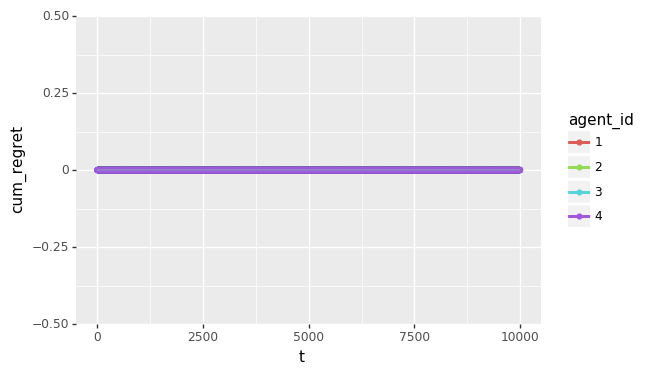

<ggplot: (8751334160049)>


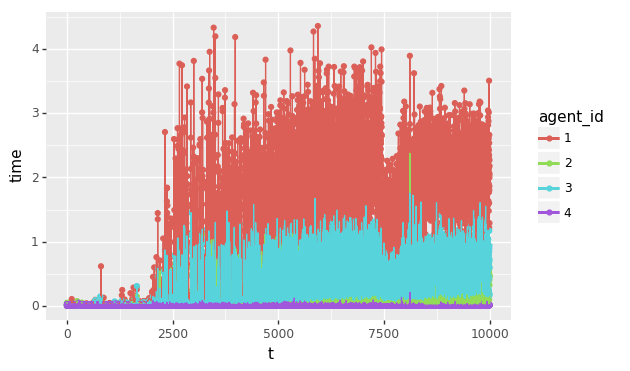

<ggplot: (8751349683037)>


([       action_id agent_id  cum_optimal  cum_regret  instant_regret      t  \
  0              1        1     0.998913         0.0             0.0      1   
  1              2        2     0.998913         0.0             0.0      1   
  2              3        3     0.998913         0.0             0.0      1   
  3              4        4     0.998913         0.0             0.0      1   
  4              5        1     1.532263         0.0             0.0      2   
  5              6        2     1.532263         0.0             0.0      2   
  6              7        3     1.532263         0.0             0.0      2   
  7              8        4     1.532263         0.0             0.0      2   
  8              9        1     1.836621         0.0             0.0      3   
  9             10        2     1.836621         0.0             0.0      3   
  10            11        3     1.836621         0.0             0.0      3   
  11            12        4     1.836621         0.0

In [6]:
agents = [make_mala_agent(),
          #make_laplace_agent(),
          make_pgts_agent(),
          make_langevin_agent(),
          make_sagald_agent()]
simple_compare(agents, num_articles, dim, var, T, 11, verbosity=1)


In [8]:
pickle.dump((agents[0].contexts,agents[0].rewards, agents[0].theta, agents[1].theta,
             agents[2].theta, agents[3].theta,
             agents[3].gradient, agents[3].gradients), open('../outputs/ma_agents_10000.p','wb'))


In [7]:
agents[0].v=1
agents[0].time=0
agents[0].n_steps=100
samples = redraw_samples(agents[0], 100, 1)

Drawing sample 1
 Sample: array([ 1.7799958 , -0.5105548 , -0.43767739, -2.75422003,  0.12328069,
       -0.17870691, -0.5010494 ,  0.62834885,  0.54274615, -1.12915059,
       -0.85127711, -0.43450825,  0.66484643,  0.6905428 , -1.50027223,
       -1.09795719,  0.665558  ,  1.59660076,  0.0108818 , -0.54732145])
 Accept proportion: 0.870000
 Steps taken: 100
Drawing sample 2
 Sample: array([ 1.78849336, -0.36145421, -0.50849519, -2.62100713,  0.16889762,
       -0.18815373, -0.55581325,  0.51738709,  0.59122259, -1.00321206,
       -0.92847512, -0.5350275 ,  0.64091697,  0.72260319, -1.24883846,
       -1.04001614,  0.70635807,  1.52957346,  0.02777829, -0.65416191])
 Accept proportion: 0.890000
 Steps taken: 100
Drawing sample 3
 Sample: array([ 1.71416851, -0.30342933, -0.38096878, -2.70922998,  0.10955762,
       -0.20077277, -0.59815872,  0.48193044,  0.57055644, -0.99685844,
       -0.91465694, -0.44187608,  0.66709329,  0.74568127, -1.41692869,
       -1.11607834,  0.7322195 ,  

KeyboardInterrupt: 

In [ ]:
pgts_agent = agents[1]
sagald_agent = agents[3]

def retime(agent, t):
    new_agent = copy.deepcopy(agent)
    new_agent.time = t
    return new_agent

"""pgts_agent_0_03 = retime(pgts_agent, 0.03)
pgts_agent_0_01 = retime(pgts_agent, 0.01)

sagald_agent_0_03 = copy.deepcopy(sagald_agent)
sagald_agent_0_03.time = 0.03
sagald_agent_0_01 = copy.deepcopy(sagald_agent)
sagald_agent_0_01.time = 0.01"""

new_agents = [pgts_agent, retime(pgts_agent, 0.03), retime(pgts_agent, 0.01),
              sagald_agent, retime(sagald_agent, 0.03), retime(sagald_agent, 0.01)
             ]

In [ ]:
samples_list = redraw_samples_for_agents(new_agents, 100, verbosity=1)
samples_list = np.append(np.asarray([samples]), samples_list, axis=0)
tvs, merrs, hists = merr(samples_list, 0.25)
merrs

In [17]:
pickle.dump(samples_list, open('../outputs/ma_times_10000.p','wb'))

In [18]:
from algorithms.langevin import *
npla.eig(logistic_Hessian(agents[0].theta, agents[0].contexts))

(array([262.38235137, 454.64169747, 383.16857379, 446.38983508,
        387.44944641, 391.26288438, 438.99794604, 437.61895982,
        435.72626536, 400.07424119, 402.31482328, 431.16800655,
        428.67218288, 404.87828782, 407.38098302, 411.9216801 ,
        415.13970272, 417.68139095, 421.61360105, 424.15715043]),
 array([[ 0.37351305,  0.15567297, -0.21637633,  0.08389841,  0.26928996,
         -0.23449836,  0.06987596,  0.06048422,  0.45303586,  0.2989964 ,
         -0.17781803, -0.34340933, -0.16685113,  0.06473503, -0.03428647,
          0.30872126, -0.20463826, -0.0716222 ,  0.16318846, -0.00279665],
        [-0.07265268, -0.13503028,  0.10001848, -0.2334384 , -0.27482259,
         -0.04664743,  0.19370959,  0.35070516, -0.02504099,  0.08490319,
         -0.17217029,  0.19931365, -0.00834781, -0.25928452,  0.01302153,
          0.52059814, -0.16871093,  0.14945187, -0.15941641,  0.42645418],
        [-0.071509  , -0.16343241,  0.00401404, -0.27801657,  0.15361028,
          

In [21]:
new_agents2 = [pgts_agent, retime(pgts_agent, 0.03), retime(pgts_agent, 0.01), retime(pgts_agent, 0.003), retime(pgts_agent, 0.001),
              sagald_agent, retime(sagald_agent, 0.03), retime(sagald_agent, 0.01), retime(sagald_agent, 0.003), retime(sagald_agent, 0.001)
             ]
samples_list2 = redraw_samples_for_agents(new_agents2, 100, verbosity=1)
samples_list2 = np.append(np.asarray([samples]), samples_list2, axis=0)
tvs2, merrs2, hists2 = merr(samples_list2, 0.25)
merrs2

Drawing sample 1
Drawing sample 2
Drawing sample 3
Drawing sample 4
Drawing sample 5
Drawing sample 6
Drawing sample 7
Drawing sample 8
Drawing sample 9
Drawing sample 10
Drawing sample 11
Drawing sample 12
Drawing sample 13
Drawing sample 14
Drawing sample 15
Drawing sample 16
Drawing sample 17
Drawing sample 18
Drawing sample 19
Drawing sample 20
Drawing sample 21
Drawing sample 22
Drawing sample 23
Drawing sample 24
Drawing sample 25
Drawing sample 26
Drawing sample 27
Drawing sample 28
Drawing sample 29
Drawing sample 30
Drawing sample 31
Drawing sample 32
Drawing sample 33
Drawing sample 34
Drawing sample 35
Drawing sample 36
Drawing sample 37
Drawing sample 38
Drawing sample 39
Drawing sample 40
Drawing sample 41
Drawing sample 42
Drawing sample 43
Drawing sample 44
Drawing sample 45
Drawing sample 46
Drawing sample 47
Drawing sample 48
Drawing sample 49
Drawing sample 50
Drawing sample 51
Drawing sample 52
Drawing sample 53
Drawing sample 54
Drawing sample 55
Drawing sample 56
D

Drawing sample 68
Drawing sample 69
Drawing sample 70
Drawing sample 71
Drawing sample 72
Drawing sample 73
Drawing sample 74
Drawing sample 75
Drawing sample 76
Drawing sample 77
Drawing sample 78
Drawing sample 79
Drawing sample 80
Drawing sample 81
Drawing sample 82
Drawing sample 83
Drawing sample 84
Drawing sample 85
Drawing sample 86
Drawing sample 87
Drawing sample 88
Drawing sample 89
Drawing sample 90
Drawing sample 91
Drawing sample 92
Drawing sample 93
Drawing sample 94
Drawing sample 95
Drawing sample 96
Drawing sample 97
Drawing sample 98
Drawing sample 99
Drawing sample 100
Drawing sample 1
Drawing sample 2
Drawing sample 3
Drawing sample 4
Drawing sample 5
Drawing sample 6
Drawing sample 7
Drawing sample 8
Drawing sample 9
Drawing sample 10
Drawing sample 11
Drawing sample 12
Drawing sample 13
Drawing sample 14
Drawing sample 15
Drawing sample 16
Drawing sample 17
Drawing sample 18
Drawing sample 19
Drawing sample 20
Drawing sample 21
Drawing sample 22
Drawing sample 23


Drawing sample 56
Drawing sample 57
Drawing sample 58
Drawing sample 59
Drawing sample 60
Drawing sample 61
Drawing sample 62
Drawing sample 63
Drawing sample 64
Drawing sample 65
Drawing sample 66
Drawing sample 67
Drawing sample 68
Drawing sample 69
Drawing sample 70
Drawing sample 71
Drawing sample 72
Drawing sample 73
Drawing sample 74
Drawing sample 75
Drawing sample 76
Drawing sample 77
Drawing sample 78
Drawing sample 79
Drawing sample 80
Drawing sample 81
Drawing sample 82
Drawing sample 83
Drawing sample 84
Drawing sample 85
Drawing sample 86
Drawing sample 87
Drawing sample 88
Drawing sample 89
Drawing sample 90
Drawing sample 91
Drawing sample 92
Drawing sample 93
Drawing sample 94
Drawing sample 95
Drawing sample 96
Drawing sample 97
Drawing sample 98
Drawing sample 99
Drawing sample 100
[array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  4,  2,
        5,  8,  5, 13, 11,  9,  7, 11,  8,  3,  3,  3,  2,  1,  0,  2,  0,
        0,  0,  0,  0,  0,  0,  0,  0,

array([0.335  , 0.3495 , 0.3595 , 0.35975, 0.334  , 0.36125, 0.341  ,
       0.34325, 0.326  , 0.505  ])

In [22]:
pickle.dump(samples_list2, open('../outputs/ma_times_10000_2.p','wb'))